# Détection de gravure par Deep Learning
### Premier modèle : 1 gravure par image
On donne une carte de normale en entrée au réseau

### Dataset

J'utilise le dataset que j'ai créé à cet effet.

Il est en local sur ma machine actuellement


In [1]:
!nvidia-smi

Thu Jul 24 15:04:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 5000                Off |   00000000:73:00.0  On |                  Off |
| 33%   34C    P8             23W /  230W |     350MiB /  16384MiB |     38%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Préparation des données

In [2]:
# groundtruth_folder = 'dataset_masdazil_1/grav'
# data_folder = 'dataset_masdazil_1/mu'
groundtruth_folder = 'dataset/dataset_masdazil_3/gravures'
data_folder = 'dataset/dataset_masdazil_3/murs'

In [5]:
import os
from sklearn.model_selection import train_test_split

# Get the list of groundtruth and data files
groundtruth_files = sorted(os.listdir(groundtruth_folder))
data_files = sorted(os.listdir(data_folder))

# Create pairs: for each groundtruth "something.png", match all data files "something_i.png"
data_pairs = []
for gt_file in groundtruth_files:
  base_name = os.path.splitext(gt_file)[0]  # "something"
  matching_data_files = [f for f in data_files if (f.startswith(base_name+"_") or f.startswith(base_name+"."))  and f.endswith('.png')]
  for file in matching_data_files:
    data_pairs.append((os.path.join(groundtruth_folder, gt_file), os.path.join(data_folder, file)))

# Split the data into training, validation, and test sets
# Let's use a split of 70% training, 15% validation, 15% testing
train_val_data, test_data = train_test_split(data_pairs, test_size=0.10, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=(0.10 / 0.90), random_state=42) # Adjust test_size for the remaining data

print(f"Total data pairs: {len(data_pairs)}")
print(f"Training data pairs: {len(train_data)}")
print(f"Validation data pairs: {len(val_data)}")
print(f"Test data pairs: {len(test_data)}")

Total data pairs: 252
Training data pairs: 200
Validation data pairs: 26
Test data pairs: 26


In [6]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import tensorflow as tf

class DataGenerator(Sequence):
    def __init__(self, data_pairs, batch_size, img_height, img_width, img_channels, data_folder, groundtruth_folder, shuffle=True):
        self.data_pairs = data_pairs
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.img_channels = img_channels
        self.data_folder = data_folder
        self.groundtruth_folder = groundtruth_folder
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data_pairs) / self.batch_size))

    def __getitem__(self, index):
        batch_pairs = self.data_pairs[index*self.batch_size:(index+1)*self.batch_size]
        images = []
        masks = []
        for mask_path, img_path in batch_pairs:
            img = load_img(img_path, target_size=(self.img_height, self.img_width), color_mode="rgb")
            mask = load_img(mask_path, target_size=(self.img_height, self.img_width), color_mode="grayscale")
            #images.append(img_to_array(img) / 255.0)
            images.append((img_to_array(img) - 127.5) / 127.5)  # Normalize to [-1, 1])
            masks.append(1 - img_to_array(mask) / 255.0)
        X = tf.convert_to_tensor(np.array(images), dtype=tf.float32)
        y = tf.cast(np.array(masks), tf.float32)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.data_pairs)


### Modèle

In [7]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 3  # 1 for grayscale
BATCH_SIZE = 16

In [14]:
from tensorflow.keras.layers import Input, Conv2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, Conv2DTranspose

def build_unet(input_shape):
    # For 2D RGB input (batch, height, width, channels), use Conv2D, MaxPooling2D, etc.
    # receptive field ~= 100x100

    inputs = Input(input_shape)

    # Downsampling
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    b = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
    b = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(b)

    # Upsampling
    u3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_initializer='he_normal')(b)
    u3 = concatenate([u3, c3])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c4)

    u2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', kernel_initializer='he_normal')(c4)
    u2 = concatenate([u2, c2])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u2)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c5)

    u1 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same', kernel_initializer='he_normal')(c5)
    u1 = concatenate([u1, c1])
    c6 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u1)
    c6 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)

    outputs = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer='he_normal')(c6)

    return Model(inputs, outputs)

def build_unet_big(input_shape):
    # receptive field ~= 800x800
    # For 2D RGB input (batch, height, width, channels), use Conv2D, MaxPooling2D, etc.

    inputs = Input(input_shape)
    # Downsampling
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p4)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c5)
    p5 = MaxPooling2D((2, 2))(c5)

    # c6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p5)
    # c6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)
    # p6 = MaxPooling2D((2, 2))(c6)

    # Bottleneck
    b = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p5)
    b = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(b)

    # Upsampling
    # u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', kernel_initializer='he_normal')(b)
    # u6 = concatenate([u6, c6])
    # c7 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u6)
    # c7 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)

    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', kernel_initializer='he_normal')(b)
    u5 = concatenate([u5, c5])
    c8 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u5)
    c8 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c8)

    u4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', kernel_initializer='he_normal')(c8)
    u4 = concatenate([u4, c4])
    c9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u4)
    c9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)

    u3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_initializer='he_normal')(c9)
    u3 = concatenate([u3, c3])
    c10 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u3)
    c10 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c10)

    u2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', kernel_initializer='he_normal')(c10)
    u2 = concatenate([u2, c2])
    c11 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u2)
    c11 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c11)

    u1 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same', kernel_initializer='he_normal')(c11)
    u1 = concatenate([u1, c1])
    c12 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u1)
    c12 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c12)

    outputs = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer='he_normal')(c12)

    return Model(inputs, outputs)

model = build_unet_big((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_23 (Conv2D)          (None, 512, 512, 16)         448       ['input_2[0][0]']             
                                                                                                  
 conv2d_24 (Conv2D)          (None, 512, 512, 16)         2320      ['conv2d_23[0][0]']           
                                                                                                  
 max_pooling2d_5 (MaxPoolin  (None, 256, 256, 16)         0         ['conv2d_24[0][0]']           
 g2D)                                                                                       

#### Champ réceptif du modèle

1/1 [==============================] - 0s 369ms/step


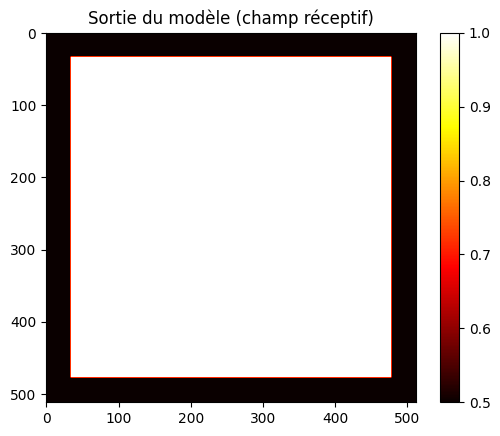

In [10]:
import numpy as np
import tensorflow as tf

# Initialiser uniquement les coefficients (poids) du modèle à 1, laisser les biais inchangés
for layer in model.layers:
    if hasattr(layer, 'kernel_initializer'):
        weights = layer.get_weights()
        if weights:
            # Généralement, le premier élément est le kernel, le second le biais (si présent)
            new_weights = []
            for i, w in enumerate(weights):
                if i == 0:  # kernel/coefficients
                    new_weights.append(np.ones(w.shape, dtype=w.dtype))
                else:  # biais ou autres
                    new_weights.append(w)
            layer.set_weights(new_weights)

# Créer une image noire avec un pixel blanc au centre
input_img = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
center_h = IMG_HEIGHT // 2
center_w = IMG_WIDTH // 2
input_img[0, center_h, center_w, :] = 1.0

# Prédiction
output = model.predict(input_img)[0, ..., 0]

import matplotlib.pyplot as plt
plt.imshow(output, cmap='hot')
plt.title("Sortie du modèle (champ réceptif)")
plt.colorbar()
plt.show()

### Training

In [9]:
# Losses
def dice_loss(y_true, y_pred, smooth=1e-8):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true*y_pred, axis=[1,2,3])
    
    # union = tf.reduce_sum(y_true + y_pred, axis=[1,2,3])
    # dice = (2. * intersection + smooth) / (union + smooth)

    den1 = tf.reduce_sum(y_true * y_true, axis=[1, 2, 3])
    den2 = tf.reduce_sum(y_pred * y_pred, axis=[1, 2, 3])
    dice = (2. * intersection + smooth) / (den1 + den2 + smooth)

    return 1 - tf.reduce_mean(dice)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

def focal_dice_loss(y_true, y_pred, lambda_bfce=1.0):
    bfce = tf.keras.losses.BinaryFocalCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return lambda_bfce * bfce + dice

# Metrics
def f1_score_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    return f1

# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint(filepath=f'checkpoints/best.weights.h5', save_weights_only=True, save_best_only=True, monitor='loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='loss', patience=10, mode='min', verbose=1)

In [12]:
train_gen = DataGenerator(train_data, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, data_folder, groundtruth_folder)
val_gen = DataGenerator(val_data, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, data_folder, groundtruth_folder, shuffle=False)
test_gen = DataGenerator(test_data, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, data_folder, groundtruth_folder, shuffle=False)

whole_gen = DataGenerator(data_pairs, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, data_folder, groundtruth_folder)

#### Learning rate Schedulers

In [11]:
import tensorflow_addons as tfa

learning_rate_start = 1e-1
learning_rate_end = 1e-4

lr_schedule_poly = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=learning_rate_start,
    decay_steps=500,
    end_learning_rate=learning_rate_end,
    power=1.0
)

lr_schedule_exp = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate_start,
    decay_steps=500,
    decay_rate= learning_rate_end / learning_rate_start,
    staircase=False
)

steps_per_epoch = len(train_data) // BATCH_SIZE
lr_schedule_cycle = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=learning_rate_start,
    maximal_learning_rate=learning_rate_end,
    step_size=2 * steps_per_epoch,
    scale_fn=lambda x: 1 / (2.0 ** (x - 1)),
    scale_mode='cycle'
)

/home/nrr6650/dev/training/.venv/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#### Fitting model

In [15]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)
adamW = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=1e-3)
sgd = tf.keras.optimizers.SGD(learning_rate=lr_schedule_cycle)

adam2 = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.5, beta_2=0.5, epsilon=1e-07, amsgrad=False)

model.compile(
    optimizer=adam2,
    loss=focal_dice_loss,
    metrics=[f1_score_metric, dice_loss]
)

history = model.fit(
    whole_gen,
    epochs=100,
    # validation_data=val_gen,
    callbacks=[checkpoint, early_stopping]
)

model.save('unet_model_from_normals.h5')

# import gc
# globals().clear()

# # kill the kernel to free up memory
# import os
# os._exit(0)  # This will terminate the kernel and free up memory


Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 1.4930 - f1_score_metric: 0.0812 - dice_loss: 0.8170
Epoch 1: loss improved from inf to 1.49301, saving model to checkpoints/best.weights.h5
16/16 [==============================] - 48s 3s/step - loss: 1.4930 - f1_score_metric: 0.0812 - dice_loss: 0.8170
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.8536 - f1_score_metric: 0.0853 - dice_loss: 0.7948
Epoch 2: loss improved from 1.49301 to 0.85361, saving model to checkpoints/best.weights.h5
16/16 [==============================] - 49s 3s/step - loss: 0.8536 - f1_score_metric: 0.0853 - dice_loss: 0.7948
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.8506 - f1_score_metric: 0.0871 - dice_loss: 0.7924
Epoch 3: loss improved from 0.85361 to 0.85056, saving model to checkpoints/best.weights.h5
16/16 [==============================] - 48s 3s/step - loss: 0.8506 - f1_score_metric: 0.0871 - dice_loss: 0.7924
Epoch 4/100
16/16 [=

/home/nrr6650/dev/training/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Prédictions

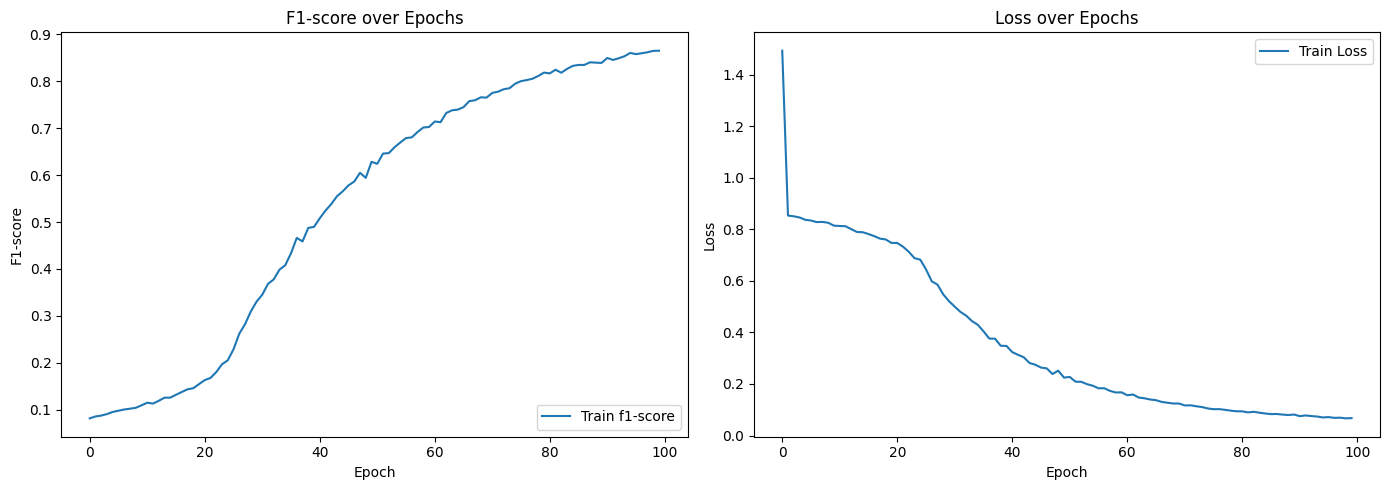

In [16]:
import matplotlib.pyplot as plt

# Récupération des données
acc = history.history['f1_score_metric']
# val_acc = history.history['val_f1_score_metric']
loss = history.history['loss']
# val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Création des graphiques
plt.figure(figsize=(14, 5))

# Précision
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train f1-score')
# plt.plot(epochs_range, val_acc, label='Val f1-score')
plt.title('F1-score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.legend(loc='lower right')

# Perte
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
# plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


2/2 [==============================] - 3s 788ms/step - loss: 0.0714 - f1_score_metric: 0.8609 - dice_loss: 0.0628
Test Loss: 0.07135066390037537, Test F1-score: 0.8609226942062378
1/1 [==============================] - 1s 1s/step


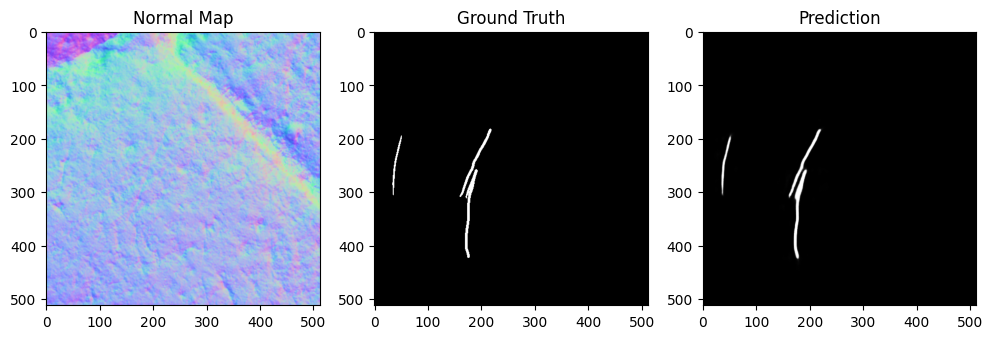

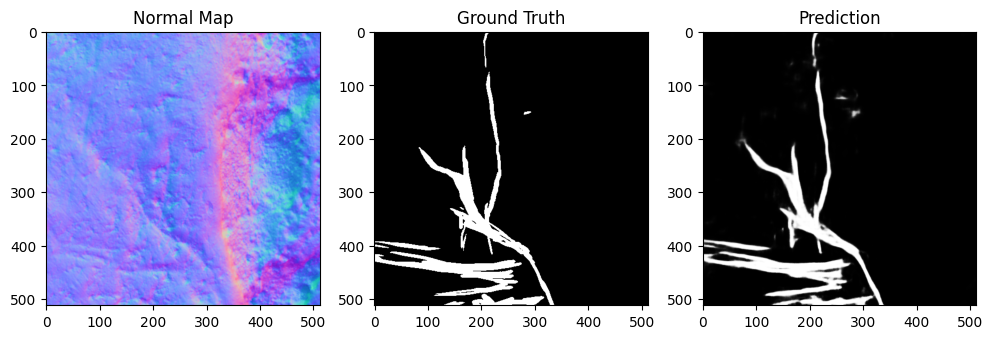

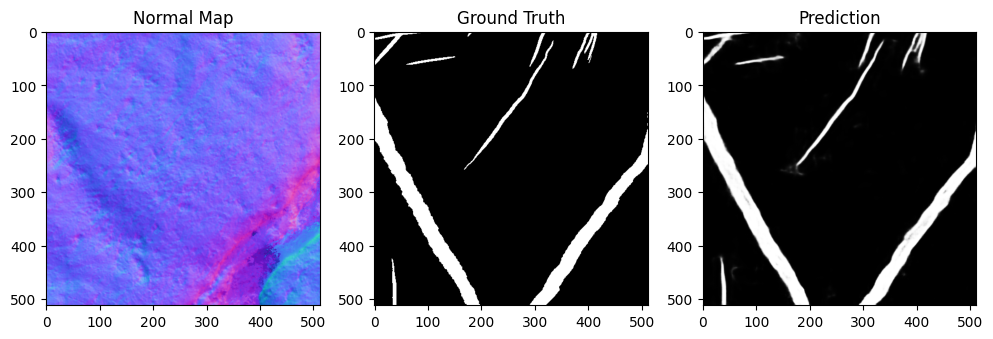

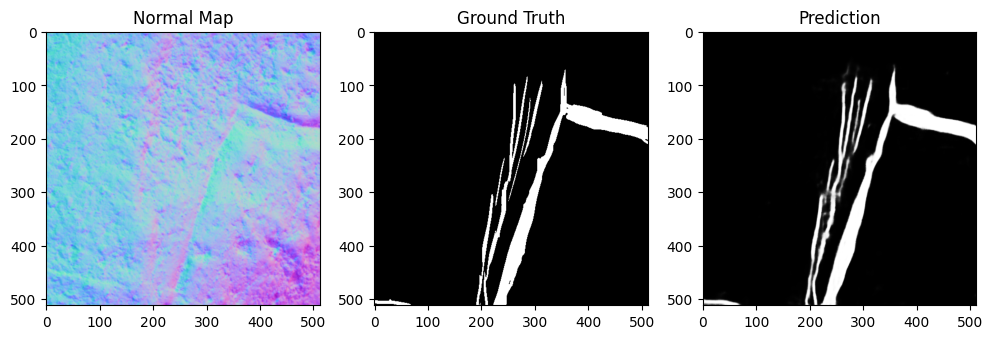

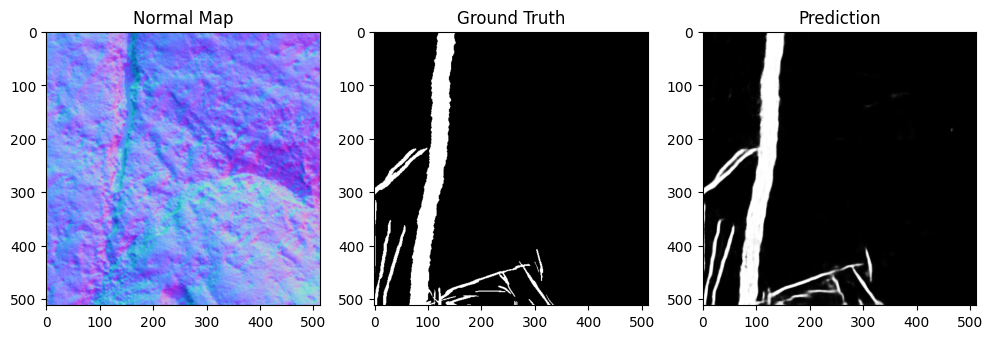

In [17]:
from tensorflow.keras.models import load_model

# Charger le modèle depuis le fichier .h5

model = load_model('unet_model_from_normals.h5', custom_objects={'focal_dice_loss': focal_dice_loss, 'f1_score_metric': f1_score_metric, 'dice_loss': dice_loss})

# Évaluation avec le générateur
loss, f1, _ = model.evaluate(test_gen)
print(f"Test Loss: {loss}, Test F1-score: {f1}")

# Prédiction sur quelques images du générateur
X_batch, y_batch = test_gen[0]  # Prend un batch
# X_batch, y_batch = train_gen[0]  # Prend un batch
preds = model.predict(X_batch)

import matplotlib.pyplot as plt

for i in range(min(5, X_batch.shape[0])):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow((X_batch[i] + 1 )/2)  # Inverse normalization to [0, 2]
    plt.title("Normal Map")

    plt.subplot(1, 3, 2)
    plt.imshow(y_batch[i, ..., 0], cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1, 3, 3)
    plt.imshow(preds[i, ..., 0], cmap='gray')
    plt.title("Prediction")
    plt.show()


### Fine Tuning avec des données annotées

In [12]:
MODEL_NAME = 'unet_model_from_normals_200ep.h5'

NEW_GROUNDTRUTH_FOLDER = 'dataset/dataset512_augmented/gravures_rot'
NEW_DATA_FOLDER = 'dataset/dataset512_augmented/murs_augmented'

BATCH_SIZE = 8

In [21]:
from tensorflow.keras.models import load_model
import os

# Charger le modèle existant
model = load_model(MODEL_NAME, custom_objects={'bce_dice_loss': focal_dice_loss, 'bce_dice_loss':bce_dice_loss, 'dice_loss': dice_loss, 'f1_score_metric': f1_score_metric})

# Générer les paires (similaire à la cellule 5)
new_groundtruth_files = sorted(os.listdir(NEW_GROUNDTRUTH_FOLDER))
new_data_files = sorted(os.listdir(NEW_DATA_FOLDER))

new_data_pairs = []
for gt_file in groundtruth_files:
  base_name = os.path.splitext(gt_file)[0]
  matching_data_files = [f for f in data_files if (f.startswith(base_name+"_") or f.startswith(base_name+"."))  and f.endswith('.png')]
  for file in matching_data_files:
    new_data_pairs.append((os.path.join(groundtruth_folder, gt_file), os.path.join(data_folder, file)))

print(f"Total new data pairs: {len(new_data_pairs)}")
# Créer un DataGenerator pour le fine-tuning
new_gen = DataGenerator(new_data_pairs, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, NEW_DATA_FOLDER, NEW_GROUNDTRUTH_FOLDER)

# Compiler le modèle pour le fine-tuning
adam3 = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.5, epsilon=1e-07, amsgrad=False)
model.compile(
    optimizer=adam3,
    loss=focal_dice_loss,
    metrics=[f1_score_metric, dice_loss]
)
# Fine-tuning du modèle
model.fit(
    new_gen,
    epochs=10,  # Ajuste le nombre d'epochs selon tes besoins
    callbacks=[checkpoint, early_stopping]
)

# Sauvegarder le modèle fine-tuné
model.save('unet_model_finetuned.h5')

Total new data pairs: 2068
Epoch 1/10
259/259 [==============================] - ETA: 0s - loss: 1.3968 - f1_score_metric: 0.0761 - dice_loss: 0.8220
Epoch 1: loss improved from inf to 1.39678, saving model to checkpoints/best.weights.h5
259/259 [==============================] - 216s 824ms/step - loss: 1.3968 - f1_score_metric: 0.0761 - dice_loss: 0.8220
Epoch 2/10
259/259 [==============================] - ETA: 0s - loss: 0.8402 - f1_score_metric: 0.0871 - dice_loss: 0.7846
Epoch 2: loss improved from 1.39678 to 0.84018, saving model to checkpoints/best.weights.h5
259/259 [==============================] - 213s 822ms/step - loss: 0.8402 - f1_score_metric: 0.0871 - dice_loss: 0.7846
Epoch 3/10
 34/259 [==>...........................] - ETA: 3:04 - loss: 0.8367 - f1_score_metric: 0.0899 - dice_loss: 0.7805

KeyboardInterrupt: 

### Utilisation sur des données réels

In [18]:
# l'image est redimensionnée à Height x Width
IMG_PATH = './omoplate.png'
MODEL_NAME = 'unet_model_from_normals_big_100ep.h5'
MODEL_WEIGHTS = 'checkpoints/best.weights.h5'

# charger le modèle avec les poids
model = load_model(MODEL_NAME, custom_objects={'focal_dice_loss': focal_dice_loss, 'f1_score_metric': f1_score_metric, 'dice_loss': dice_loss})
model.load_weights(MODEL_WEIGHTS)

1/1 [==============================] - 0s 356ms/step


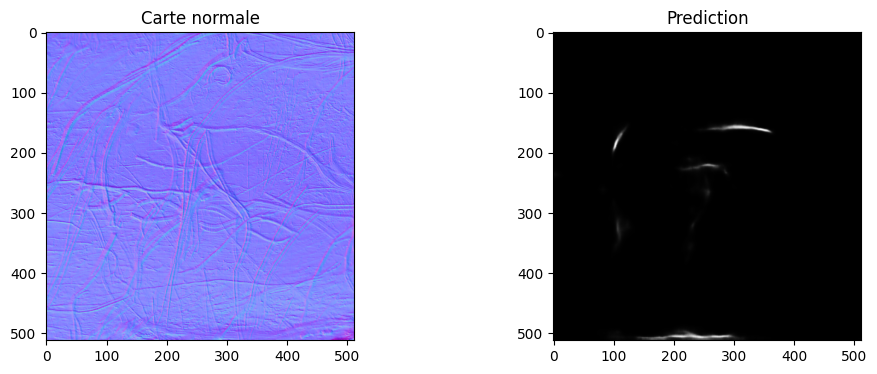

In [19]:
# Charger et prétraiter la carte normale
carte_normale = load_img(IMG_PATH, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="rgb")
carte_normale_arr = img_to_array(carte_normale) / 255.0
carte_normale_arr = np.expand_dims(carte_normale_arr, axis=0)  # shape: (1, H, W, 3)

# Prédiction du modèle
pred = model.predict(carte_normale_arr)[0]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(carte_normale)
plt.title("Carte normale")

plt.subplot(1, 2, 2)
plt.imshow(pred, cmap='gray')
plt.title("Prediction")
plt.show()